# Filter lexicon
In which we attempt to remove all noisy mentions from the lexicon:

- `salon`
- `rio`
- `shelter`

With rule-based and statistical methods.

In [27]:
import pandas as pd
import data_helpers
reload(data_helpers)
from data_helpers import load_lexicon
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load data, lexicon

In [28]:
all_group_data = pd.read_csv('../../data/facebook-maria/combined_group_data.tsv', sep='\t', index_col=False, encoding='utf-8')
lexicon = load_lexicon()

In [29]:
print('%d unique toponyms in lexicon'%(len(lexicon)))

31604 unique toponyms in lexicon


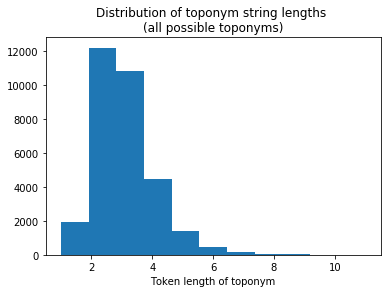

In [30]:
# distribution by token length
lexicon_token_lengths = pd.Series(map(lambda x: len(x.split(' ')), lexicon))
bins = lexicon_token_lengths.nunique()
plt.hist(lexicon_token_lengths, bins=bins)
plt.xlabel('Token length of toponym')
plt.title("Distribution of toponym string lengths \n(all possible toponyms)")
plt.show()

Most toponyms have two or three words.

What if we restrict to toponyms observed in the data?

In [31]:
# first extract from data
import data_helpers
reload(data_helpers)
from data_helpers import collect_lexicon_toponyms_from_txt
txt = all_group_data.loc[:, 'status_message'].values.tolist()
toponym_list = collect_lexicon_toponyms_from_txt(txt, lexicon)
toponym_list_flat = reduce(lambda x,y: x+y, toponym_list)
toponym_set = set(toponym_list_flat)
print('%d total toponyms in data'%(len(toponym_list_flat)))
print('%d unique toponyms in data'%(len(toponym_set)))

46301 total toponyms in data
2068 unique toponyms in data


In [32]:
print(toponym_lengths.nunique())

5


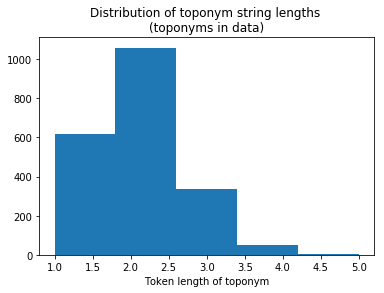

In [33]:
toponym_lengths = pd.Series(map(lambda x: len(x.split(' ')), toponym_set))
bins = toponym_lengths.nunique()
plt.hist(toponym_lengths, bins=bins)
plt.xlabel('Token length of toponym')
plt.title("Distribution of toponym string lengths \n(toponyms in data)")
plt.show()

OK! Larger proportion of single-token toponyms in data. 

Let's see the most frequent toponyms in each category.

In [34]:
from collections import Counter
toponym_frequency = pd.Series(Counter(toponym_list_flat))
toponym_data = pd.DataFrame()
toponym_data.loc[:, 'f'] = toponym_frequency
toponym_data.loc[:, 'len'] = map(lambda x: len(x.split(' ')), toponym_data.index.tolist())
toponym_data.sort_values('len', inplace=True, ascending=True)
top_k = 20
for l, l_group in toponym_data.groupby('len'):
    print('testing length %d'%(l))
    l_group.sort_values('f', inplace=True, ascending=False)
    print(l_group.loc[:, 'f'].head(top_k))
    print(l_group.loc[:, 'f'].tail(top_k))

testing length 1


/hg190/istewart6/crisis_language/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


pueblo          1412
guayama         1289
coamo            924
barranquitas     684
quebradillas     623
ponce            607
carmen           554
correo           527
yabucoa          505
corozal          494
torres           478
patillas         461
camino           414
nuevo            405
cayey            400
santiago         384
arroyo           366
cidra            358
florida          348
jardines         336
Name: f, dtype: int64
islote         1
visitantes     1
vapor          1
teatro         1
tjua           1
lluveras       1
topeka         1
toral          1
buso           1
torrimar       1
forest         1
tostado        1
lechuga        1
amaury         1
bufalo         1
trinitarias    1
berio          1
unsure         1
riachuelo      1
espana         1
Name: f, dtype: int64
testing length 2
puerto rico        2038
vega alta           712
vega baja           472
san juan            435
san antonio         187
las casas           172
santa ana           164
los llanos 

OK! 

- Most common length-1 toponyms are common words (`nuevo`, `camino`) or municipality names, or maybe names (`serafina`).
- Some common length-2 toponyms could be common words (`la plaza`, `el centro`) and the long tail comprises street names (`calle 48`).

## Frequency-based filtering
What if we remove all toponyms that have high frequency in some external corpus? This would hopefully eliminate errors like `shelter` and `salon` plus names like `laura`, without eliminating less-common but still important toponyms like `calle 1`.

Start with sample day from archive (20 Sep 2017 because of proximity to hurricane), maybe use "official" corpus like [this](https://www.corpusdelespanol.org/x.asp?c=3).

In [41]:
import re
HANDLE_MATCHER = re.compile('@\w+')
HASHTAG_MATCHER = re.compile('#\w+')
URL_MATCHER = re.compile('https?://\S+|pic.twitter.com/\S+')
MATCHERS = [HANDLE_MATCHER, HASHTAG_MATCHER, URL_MATCHER]
test = '@anderson check out this #dope video https://www.blah.com/012354-39032.html'
for m in MATCHERS:
    test = m.sub('', test)
print(test)

 check out this  video 


In [ ]:
from nltk.tokenize.casual import TweetTokenizer
import gzip
import json
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
archive_file = '/hg190/corpora/twitter-crawl/new-archive/tweets-Sep-20-17-03-57.gz'
tokenizer = TweetTokenizer()
tf = Counter()
# remove handles, hashtags, URLs
HANDLE_MATCHER = re.compile('@\w+')
HASHTAG_MATCHER = re.compile('#\w+')
URL_MATCHER = re.compile('https?://\S+|pic.twitter.com/\S+')
NUM_MATCHER = re.compile('[\d\.]+')
MATCHERS = [(HANDLE_MATCHER, ''), (HASHTAG_MATCHER, ''), 
            (URL_MATCHER, '<URL>'), (NUM_MATCHER, '<NUM>')]
ngram_range = (1,3)
def tweet_generator(f):
    for l in gzip.open(f, 'r'):
        try:
            l_json = json.loads(l.strip())
            l_txt = l_json.get('text')
            l_lang = l_json.get('lang')
            if(l_txt is not None and l_lang == 'es'):
                l_txt = l_txt.lower()
                for m, sub in MATCHERS:
                    l_txt = m.sub(sub, l_txt)
                yield l_txt
            else:
                yield ''
        except Exception, e:
            yield ''
cv = CountVectorizer(lowercase=True, ngram_range=ngram_range, tokenizer=tokenizer.tokenize)
dtm = cv.fit_transform(tweet_generator(archive_file))
# for i, l in enumerate(gzip.open(archive_file, 'r')):
#     try:
#         l_json = json.loads(l.strip())
#         l_txt = l_json.get('text')
#         l_lang = l_json.get('lang')
#         if(l_txt is not None and l_lang == 'es'):
#             l_txt = l_txt.lower()
#             for m in MATCHERS:
#                 l_txt = m.sub('', l_txt)
#             # unigrams
#             l_tokens = tokenizer.tokenize(l_txt)
#             # 2,3,4 grams
#             tf.update(l_tokens)
#     except Exception, e:
#         pass
#     if(i % 1000000 == 0):
#         print('processed %d tweets'%(i))

In [59]:
print(dtm.shape)

(4671293, 3286910)


In [61]:
# get term counts
ivoc = {v : k for k,v in cv.vocabulary_.iteritems()}
dtm_sum = pd.np.array(dtm.sum(axis=0))[0]
print(dtm_sum)
dtm_sum = pd.Series(dict([(ivoc[i], x) for i, x in enumerate(dtm_sum)]))
print(dtm_sum.head(20))
print(dtm_sum.sort_values(inplace=False, ascending=False))

[66435 21253  7254 ...,     2     1     1]
!              66435
! !            21253
! ! !           7254
! ! "             86
! ! #              6
! ! #éxitos        1
! ! %              1
! ! &              1
! ! '              5
! ! (             81
! ! (:             1
! ! )             25
! ! ):             1
! ! *             11
! ! +             17
! ! ,             48
! ! -             21
! ! ->             3
! ! :             18
! ! :')            1
dtype: int64
<num>                       323076
:                           316167
rt                          286400
rt :                        270151
de                          237732
,                           176708
<url>                       173930
en                          145547
la                          136256
que                         135115
a                           127974
y                           117998
…                           113527
el                          110658
�                            89472

In [63]:
from __future__ import division
# normalize for frequency
dtm_sum /= dtm_sum.sum()
print(dtm_sum.head(10))

!              3.362632e-03
! !            1.075728e-03
! ! !          3.671639e-04
! ! "          4.352922e-06
! ! #          3.036922e-07
! ! #éxitos    5.061537e-08
! ! %          5.061537e-08
! ! &          5.061537e-08
! ! '          2.530768e-07
! ! (          4.099845e-06
dtype: float64


In [69]:
# figure out overlap in sample and lexicon
overlap_mentions = set(dtm_sum.index) & set(toponym_list_flat)
print('%d overlaps'%(len(overlap_mentions)))
dtm_overlap = dtm_sum.loc[overlap_mentions].sort_values(inplace=False, ascending=False)
print(dtm_overlap.head(20))
print(dtm_overlap.tail(20))

753 overlaps
edificio       0.000282
nuevo          0.000175
escuela        0.000173
fuerte         0.000167
venezuela      0.000166
pueblo         0.000153
roma           0.000117
amigo          0.000090
claro          0.000055
puerto rico    0.000051
el centro      0.000049
seguridad      0.000045
madrid         0.000039
monterrey      0.000038
estadio        0.000037
pena           0.000036
esperanza      0.000034
camino         0.000029
total          0.000029
maldonado      0.000029
dtype: float64
calle gibraltar      5.061537e-08
ramos antonini       5.061537e-08
santa teresita       5.061537e-08
calle girasoles      5.061537e-08
la alborada          5.061537e-08
el roble             5.061537e-08
perchas              5.061537e-08
el pueblito          5.061537e-08
la lomita            5.061537e-08
sol y mar            5.061537e-08
morovis              5.061537e-08
barranquitas         5.061537e-08
hogar de ancianos    5.061537e-08
belmonte             5.061537e-08
terranova       

In [75]:
# 95 percentile cutoff?
cutoff_percentile = 95
cutoff = pd.np.percentile(dtm_sum, cutoff_percentile)
dtm_overlap_cutoff = dtm_overlap[dtm_overlap >= cutoff]
print('%d overlap words over cutoff %.3E'%(len(dtm_overlap_cutoff), cutoff))
# print(dtm_overlap_cutoff.head(50))
print(','.join(sorted(dtm_overlap_cutoff.index.tolist())))

372 overlap words over cutoff 5.062E-07
aaa,abandonado,acevedo,acosta,aduana,aguacate,aguadilla,aguirre,alianza,alicia,altagracia,amado,amador,amigo,amy,anabel,angel,angelitos,arecibo,arroyo,asilo,atenas,ballena,barcelona,barranca,beatriz,bellas artes,benitez,bodega,brooklyn,buenos aires,cacao,caguas,cajero,calle a,calle y,cam,camino,camino a,camino real,campamento,cana,cancha,cantera,carcel,caribe,carmen,carolina,carro,casa blanca,casino,castillo,catalina,catedral,centro comercial,centro de salud,ciudad universitaria,claro,coco,combate,cometa,concordia,constancia,consumo,correo,costco,cristina,cristobal,cuba,cueva,cuevas,de diego,del carmen,del sol,delgado,delicias,dentista,deportivo,destino,doctor,dorado,duque,edificio,edificio a,el alto,el banco,el bosque,el cachete,el carmen,el centro,el cerro,el chino,el corte,el lago,el mono,el negro,el ojo,el parque,el punto,el recreo,el saco,el sombrero,el taller,el valle,el verde,elizabeth,encantada,entrada,escaleras,escuela,esperanza,espinosa

Hmm...this is good because of all the common words it elmiinates:

- `abandonado`
- `amigo`
- `la plaza`
- `total`

But it's bad because of how many toponyms it eliminates:

- `caribe`
- `olimpo` (neighborhood)
- `padilla` (city)
- `paris` (city)

Stronger cutoff?

In [76]:
# 95 percentile cutoff?
cutoff_percentile = 99
cutoff = pd.np.percentile(dtm_sum, cutoff_percentile)
dtm_overlap_cutoff = dtm_overlap[dtm_overlap >= cutoff]
print('%d overlap words over cutoff %.3E'%(len(dtm_overlap_cutoff), cutoff))
print(','.join(sorted(dtm_overlap_cutoff.index.tolist())))

162 overlap words over cutoff 2.632E-06
aaa,alianza,amado,amigo,angel,asilo,barcelona,buenos aires,calle y,camino,camino a,cancha,caribe,carmen,carolina,carro,castillo,centro comercial,claro,coco,combate,consumo,correo,cristina,cuba,deportivo,destino,doctor,edificio,el banco,el cachete,el centro,el ojo,el parque,el punto,elizabeth,entrada,escuela,esperanza,espinosa,estadio,estudiantes,fajardo,fortuna,fuerte,garcia,gimnasio,gomez,gutierrez,gym,honduras,israel,la barra,la boca,la cadena,la capital,la esperanza,la esquina,la fe,la fuente,la junta,la luna,la madre,la mesa,la mina,la parada,la paz,la plata,la playa,la plaza,la respuesta,la torre,la vista,las casas,las mesas,las palmas,las vegas,laura,lomas,los morales,los muertos,los perros,los pinos,luna,madrid,magdalena,maldonado,mantenimiento,margarita,mariana,marina,marta,mayo,medina,melendez,mendoza,mercado,mia,miel,milagros,miranda,monterrey,mora,morales,muro,museo,nuevo,obrero,oficina,oriental,oriente,padilla,palmas,pasos,pena,pico,p

This looks a little less bad:

- `amigo`
- `camino`
- `doctor`
- `el centro`
- `gym`
- `la playa`
- `museo`
- `nuevo`
- `puerto rico`
- `rio`
- `san juan`

If we make exceptions for municipalities (`caribe`, `padilla`, `ponce`) then this should work.

In [52]:
tf_series = pd.Series(tf).sort_values(inplace=False, ascending=False)
tf_norm = tf_series / tf_series.sum()
print(tf_norm.head(20))

:       0.046018
rt      0.042193
de      0.035021
.       0.027075
,       0.025666
en      0.021438
la      0.020069
que     0.019906
a       0.018819
y       0.017381
…       0.016727
el      0.016289
�       0.013183
no      0.011931
!       0.009789
por     0.008774
se      0.008716
los     0.008267
para    0.007046
es      0.006874
dtype: float64
